# Functions

In [2]:
import pandas as pd
import urllib, json
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

def get_rki(try_max = 10):

    '''
    Downloads Robert Koch Institute data, separated by region (landkreis)
    
    Returns
    -------
    dataframe
        dataframe containing all the RKI data from arcgis.
    
    Parameters
    ----------
    try_max : int, optional
        Maximum number of tries for each query.
    '''

    landkreise_max = 413

    #Gets all unique landkreis_id from data
    url_id = 'https://services7.arcgis.com/mOBPykOjAyBO2ZKk/ArcGIS/rest/services/RKI_COVID19/FeatureServer/0/query?where=0%3D0&objectIds=&time=&resultType=none&outFields=idLandkreis&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnDistinctValues=true&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&sqlFormat=none&f=pjson&token='
    url = urllib.request.urlopen(url_id)
    json_data = json.loads(url.read().decode())
    n_data = len(json_data['features'])
    unique_ids = [json_data['features'][i]['attributes']['IdLandkreis'] for i in range(n_data)]

    #If the number of landkreise is smaller than landkreise_max, fails (query system can behave weirdly during updates)
    if n_data >= landkreise_max:

        print('Downloading {:d} unique Landkreise. May take a while.\n'.format(n_data))

        df_keys = ['Bundesland', 'Landkreis', 'Altersgruppe', 'Geschlecht', 'AnzahlFall',
           'AnzahlTodesfall', 'Meldedatum', 'NeuerFall', 'NeuGenesen', 'AnzahlGenesen','Refdatum']

        df = pd.DataFrame(columns=df_keys)

        #Fills DF with data from all landkreise
        for idlandkreis in unique_ids:
            
            url_str = 'https://services7.arcgis.com/mOBPykOjAyBO2ZKk/ArcGIS/rest/services/RKI_COVID19/FeatureServer/0//query?where=IdLandkreis%3D'+ idlandkreis + '&objectIds=&time=&resultType=none&outFields=Bundesland%2C+Landkreis%2C+Altersgruppe%2C+Geschlecht%2C+AnzahlFall%2C+AnzahlTodesfall%2C+Meldedatum%2C+NeuerFall%2C+Refdatum%2C+NeuGenesen%2C+AnzahlGenesen&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&sqlFormat=none&f=pjson&token='

            count_try = 0

            while count_try < try_max:
                try:
                    with urllib.request.urlopen(url_str) as url:
                        json_data = json.loads(url.read().decode())

                    n_data = len(json_data['features'])

                    if n_data > 5000:
                        raise ValueError('Query limit exceeded')

                    data_flat = [json_data['features'][i]['attributes'] for i in range(n_data)]

                    break

                except:
                    count_try += 1           

            if count_try == try_max:
                raise ValueError('Maximum limit of tries exceeded.')

            df_temp = pd.DataFrame(data_flat)
        
            #Very inneficient, but it will do
            df = pd.concat([df, df_temp], ignore_index=True)

        df['date'] = df['Meldedatum'].apply(lambda x: datetime.datetime.fromtimestamp(x/1e3))  
        df['date_ref'] = df['Refdatum'].apply(lambda x: datetime.datetime.fromtimestamp(x/1e3))

    else:
        raise ValueError("Warning: Query returned {:d} landkreise (out of {:d}), likely being updated at the moment. Try again later.".format(n_data, landkreise_max))

    return df

In [3]:
df = get_rki()

In [19]:
# Plotting parameters
date_data_begin = datetime.datetime(2020,3,1)
date_data_end   = datetime.datetime(2020,4,14)
variable = 'AnzahlFall'

# Germany

Text(0.5, 0, 'days')

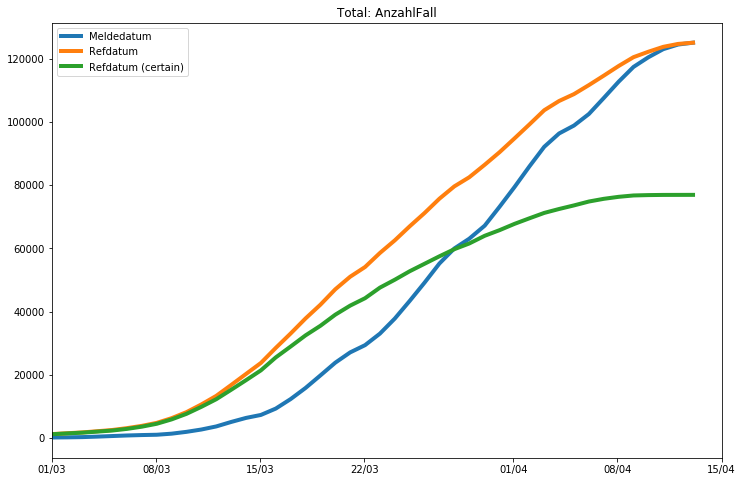

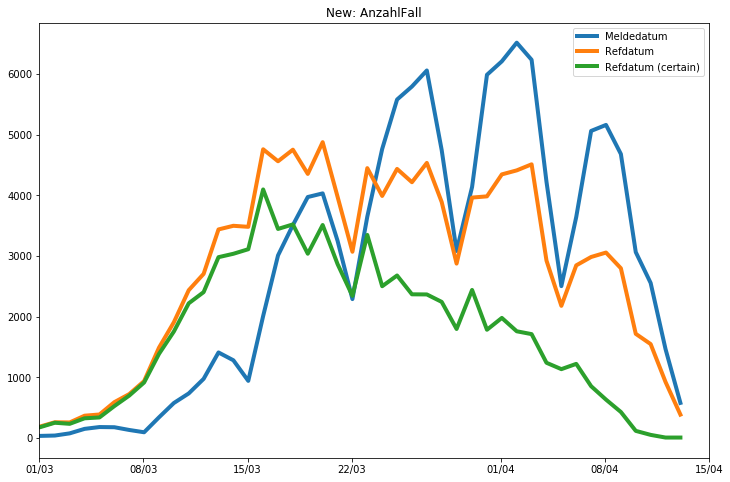

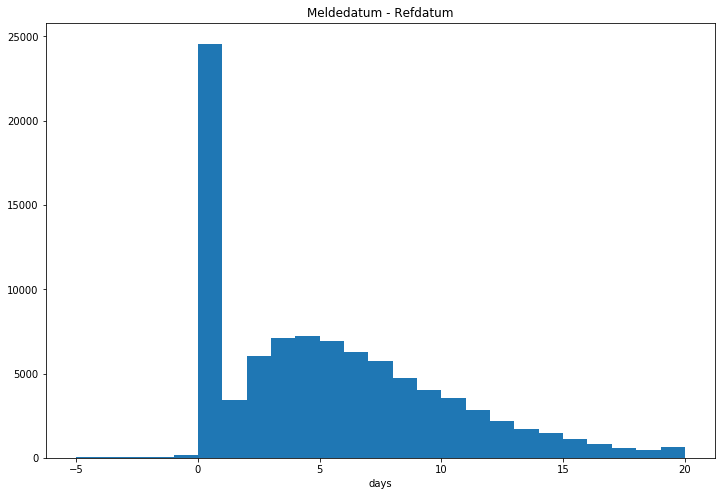

In [20]:
df['date_diff_days'] = (df['date'] - df['date_ref']).apply(lambda x:x.days)
series_melde = df.groupby('date')[variable].sum().cumsum()
series_ref = df.groupby('date_ref')[variable].sum().cumsum()
series_ref_certain = df[df['date_diff_days'] != 0].groupby('date_ref')[variable].sum().cumsum()

plt.figure(figsize=(12,8))
plt.plot(series_melde, label='Meldedatum', lw=4)
plt.plot(series_ref,label='Refdatum', lw=4)
plt.plot(series_ref_certain,label='Refdatum (certain)', lw=4)
plt.title('Total: ' + variable)
plt.xlim([datetime.datetime(2020,3,1), datetime.datetime(2020,4,15)])
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.legend()
         
plt.figure(figsize=(12,8))
plt.plot(series_melde.diff(),label='Meldedatum', lw=4)
plt.plot(series_ref.diff(),label='Refdatum', lw=4)
plt.plot(series_ref_certain.diff(),label='Refdatum (certain)', lw=4)
plt.title('New: ' + variable)
plt.xlim([datetime.datetime(2020,3,1), datetime.datetime(2020,4,15)])
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.legend()

plt.figure(figsize=(12,8))
df['date_diff'] = df['date'] - df['date_ref']
plt.hist(df['date_diff_days'].to_list(), bins=25, range=[-5,20])
plt.title('Meldedatum - Refdatum')
plt.xlabel('days')

# Niedersachsen

Text(0.5, 0, 'days')

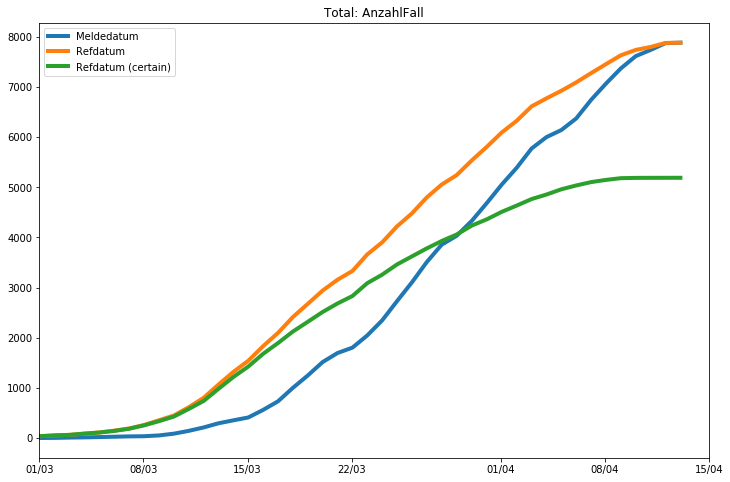

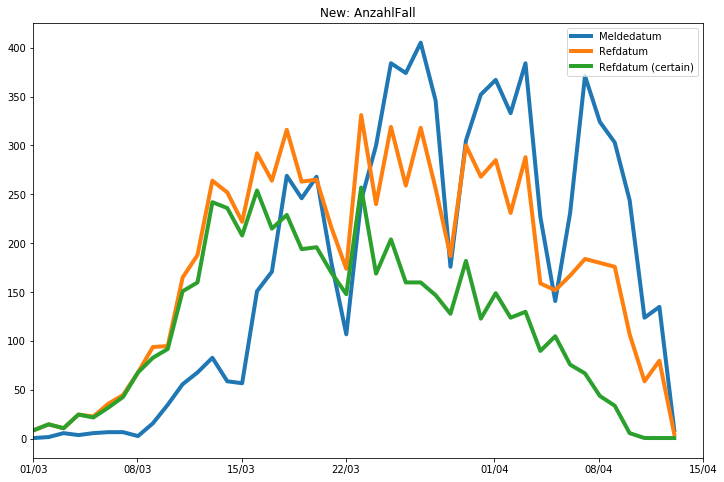

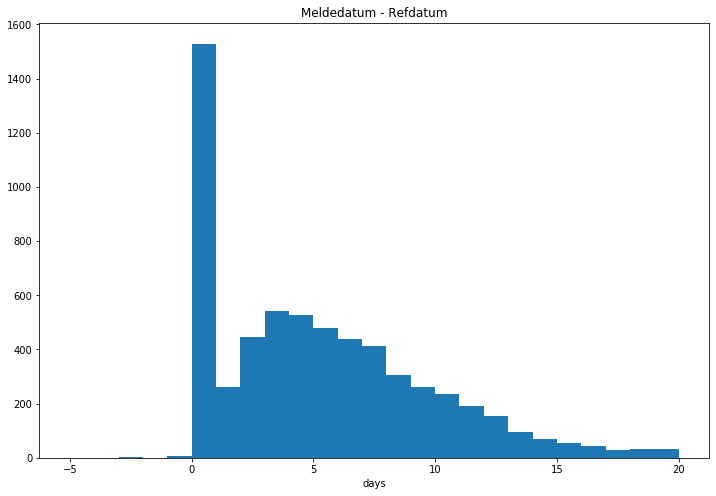

In [21]:
df_ns = df[df['Bundesland'] == 'Niedersachsen'][[variable, 'date', 'date_ref']]

df_ns['date_diff_days'] = (df_ns['date'] - df_ns['date_ref']).apply(lambda x:x.days)
series_melde = df_ns.groupby('date')[variable].sum().cumsum()
series_ref = df_ns.groupby('date_ref')[variable].sum().cumsum()
series_ref_certain = df_ns[df_ns['date_diff_days'] != 0].groupby('date_ref')[variable].sum().cumsum()

plt.figure(figsize=(12,8))
plt.plot(series_melde, label='Meldedatum', lw=4)
plt.plot(series_ref,label='Refdatum', lw=4)
plt.plot(series_ref_certain,label='Refdatum (certain)', lw=4)
plt.title('Total: ' + variable)
plt.xlim([datetime.datetime(2020,3,1), datetime.datetime(2020,4,15)])
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.legend()
         
plt.figure(figsize=(12,8))
plt.plot(series_melde.diff(),label='Meldedatum', lw=4)
plt.plot(series_ref.diff(),label='Refdatum', lw=4)
plt.plot(series_ref_certain.diff(),label='Refdatum (certain)', lw=4)
plt.title('New: ' + variable)
plt.xlim([datetime.datetime(2020,3,1), datetime.datetime(2020,4,15)])
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.legend()

plt.figure(figsize=(12,8))
df_ns['date_diff'] = df_ns['date'] - df_ns['date_ref']
plt.hist(df_ns['date_diff_days'].to_list(), bins=25, range=[-5,20])
plt.title('Meldedatum - Refdatum')
plt.xlabel('days')

# Goettingen Landkreis

Text(0.5, 0, 'days')

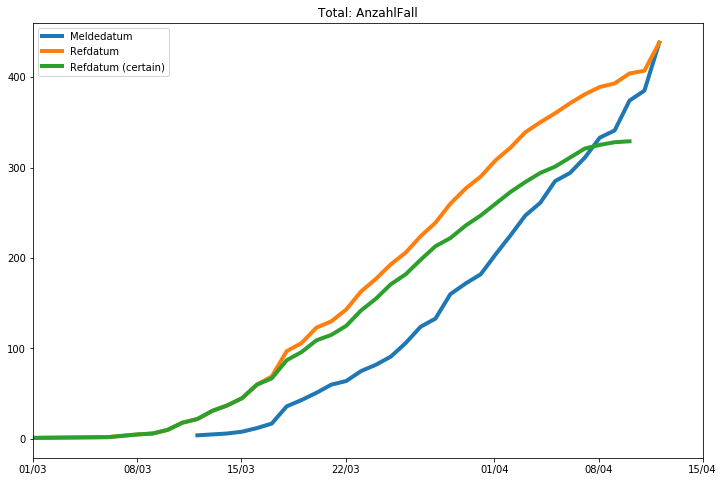

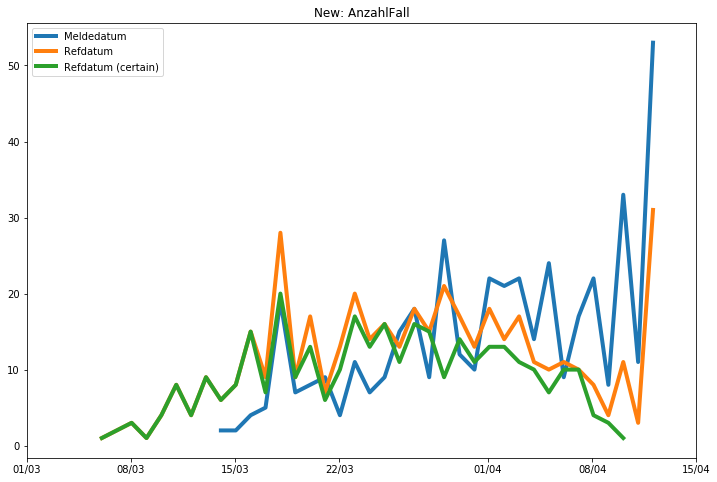

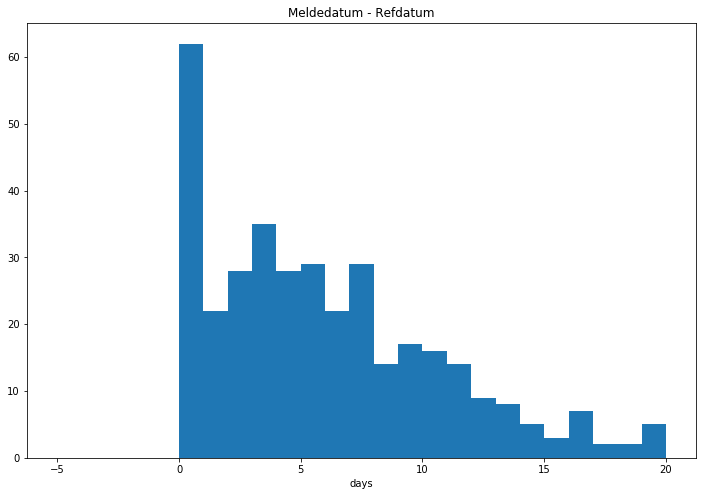

In [22]:
df_go = df[df['Landkreis'] == 'LK Göttingen'][[variable, 'date', 'date_ref']]

df_go['date_diff_days'] = (df_go['date'] - df_go['date_ref']).apply(lambda x:x.days)
series_melde = df_go.groupby('date')[variable].sum().cumsum()
series_ref = df_go.groupby('date_ref')[variable].sum().cumsum()
series_ref_certain = df_go[df_go['date_diff_days'] != 0].groupby('date_ref')[variable].sum().cumsum()

plt.figure(figsize=(12,8))
plt.plot(series_melde, label='Meldedatum', lw=4)
plt.plot(series_ref,label='Refdatum', lw=4)
plt.plot(series_ref_certain,label='Refdatum (certain)', lw=4)
plt.title('Total: ' + variable)
plt.xlim([datetime.datetime(2020,3,1), datetime.datetime(2020,4,15)])
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.legend()
         
plt.figure(figsize=(12,8))
plt.plot(series_melde.diff(),label='Meldedatum', lw=4)
plt.plot(series_ref.diff(),label='Refdatum', lw=4)
plt.plot(series_ref_certain.diff(),label='Refdatum (certain)', lw=4)
plt.title('New: ' + variable)
plt.xlim([datetime.datetime(2020,3,1), datetime.datetime(2020,4,15)])
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.legend()

plt.figure(figsize=(12,8))
df_go['date_diff'] = df_go['date'] - df_go['date_ref']
plt.hist(df_go['date_diff_days'].to_list(), bins=25, range=[-5,20])
plt.title('Meldedatum - Refdatum')
plt.xlabel('days')